In [ ]:
# %%

import holidays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

In [ ]:
# %%

# Load and display the data
solar_232215 = pd.read_csv('data/solar_232215.csv', delimiter=',', decimal='.')
solar_232215

,timestamp,raw,temperature,modified1,modified2,modified3
0,1612224000000,0.0,-3.9,0.0,0.0,0.0
1,1612227600000,0.0,-3.5,0.0,0.0,0.0
2,1612231200000,0.0,-3.0,0.0,0.0,0.0
3,1612234800000,0.0,-2.6,0.0,0.0,0.0
4,1612238400000,0.0,-2.4,0.0,0.0,0.0
...,...,...,...,...,...,...
17011,1675278000000,0.0,0.0,0.0,0.0,0.0
17012,1675281600000,0.0,0.1,0.0,0.0,0.0
17013,1675285200000,0.0,0.1,0.0,0.0,0.0
17014,1675288800000,0.0,0.2,0.0,0.0,0.0


# %% [markdown]

 The dataset consists of 17,016 entries with six columns:
 1. **timestamp**: Unix timestamp (in milliseconds).
 2. **raw**: Electricity production from the PV panel corresponding to each timestamp.
 3. **temperature**: Temperature readings corresponding to each timestamp.
 4. **modified1, modified2, modified3**: Modified versions of the raw production data. These columns have some missing values.

 Overall with the provided data it is possible to analyze the electricity production of the PV panel and its relationship with temperature.

 To analyze the PV panel's production effectively, the following potential external data sources might be useful:
 1. **Solar Irradiance Data**: Information on solar irradiance levels (sunlight intensity) would help assess the PV production in relation to the available sunlight.
 2. **Weather Conditions**: Data on cloud cover, humidity, or precipitation could help explain variations in electricity production that temperature alone might not cover.
 3. **Panel Specifications**: Knowing the panel's efficiency, orientation, and tilt would allow for a more accurate interpretation of the production data.
 4. **Special Dates**: Information on special events, holidays, or maintenance work could explain anomalies in the production data.

In [ ]:
# %%

# Convert timestamp from milliseconds to a readable datetime format and analyze the time range
data = solar_232215.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

time_period_start = data['timestamp'].min()
time_period_end = data['timestamp'].max()

time_period_start, time_period_end, data['timestamp'].dt.year.value_counts()

(Timestamp('2021-02-02 00:00:00'),
 Timestamp('2023-02-01 23:00:00'),
 timestamp
 2022    8760
 2021    7752
 2023     504
 Name: count, dtype: int64)

# %% [markdown]

 The dataset spans from February 2, 2021, to February 1, 2023. Data coverage by year:
 1. 2021: Partial data, covering from February 2 onward, with 7,752 hours.
 2. 2022: Full year, with 8,760 hours.
 3. 2023: Partial data, covering until February 1, with 504 hours

In [ ]:
# %%

# Set the timestamp as the index of the DataFrame for easier time-based analysis
data.set_index('timestamp', inplace=True)
data

,raw,temperature,modified1,modified2,modified3
timestamp,,,,,
2021-02-02 00:00:00,0.0,-3.9,0.0,0.0,0.0
2021-02-02 01:00:00,0.0,-3.5,0.0,0.0,0.0
2021-02-02 02:00:00,0.0,-3.0,0.0,0.0,0.0
2021-02-02 03:00:00,0.0,-2.6,0.0,0.0,0.0
2021-02-02 04:00:00,0.0,-2.4,0.0,0.0,0.0
...,...,...,...,...,...
2023-02-01 19:00:00,0.0,0.0,0.0,0.0,0.0
2023-02-01 20:00:00,0.0,0.1,0.0,0.0,0.0
2023-02-01 21:00:00,0.0,0.1,0.0,0.0,0.0


In [ ]:
# %%

data.describe()

,raw,temperature,modified1,modified2,modified3
count,17016.000000,17016.000000,15825.000000,15641.000000,15879.000000
mean,36912.094888,6.609191,37011.205491,25506.277558,33958.829309
std,66907.410347,9.292033,67030.848200,50828.415005,65118.934709
min,0.000000,-24.500000,0.000000,0.000000,0.000000
25%,0.000000,-0.200000,0.000000,0.000000,0.000000
50%,0.000000,6.400000,0.000000,0.000000,0.000000
75%,38258.015000,13.400000,38577.170000,22090.490000,30661.975000
max,301630.010000,30.100000,301453.360000,266069.210000,301630.010000


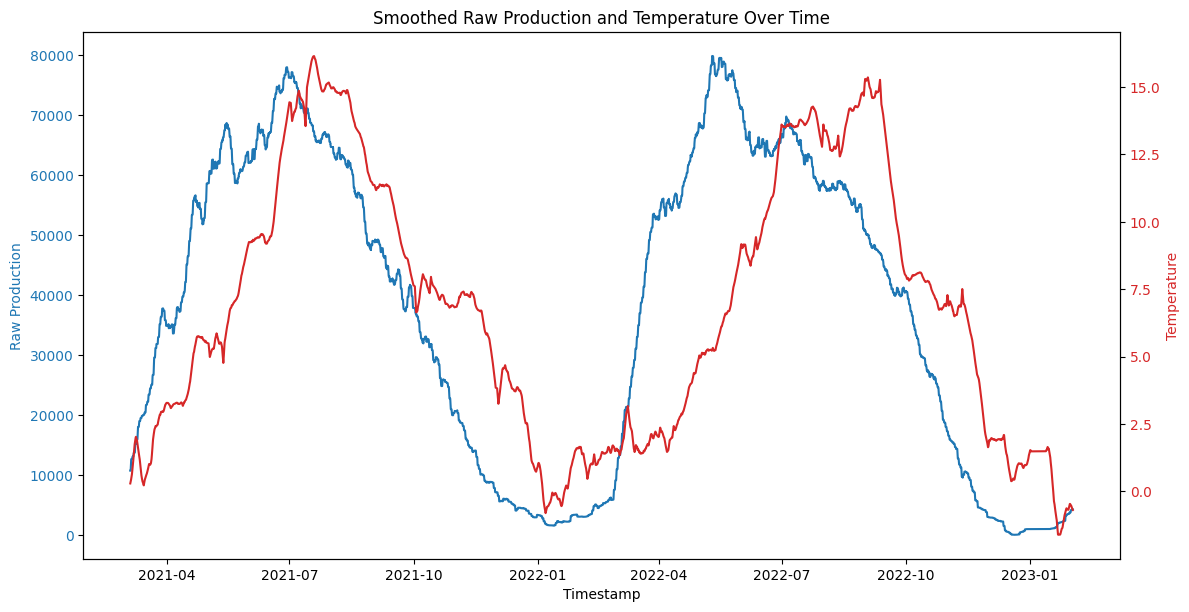

In [ ]:
# %%

# Plot the smoothed raw production and temperature data
#
# Apply rolling average to smooth lines (with a rough (24 hours * 30 days) monthly window size)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot smoothed raw production data on primary y-axis
ax1.plot(data.index, data['raw'].rolling(window=24 * 30).mean(),
         color='tab:blue', label='Smoothed Raw Production')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Raw Production', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for smoothed temperature data
ax2 = ax1.twinx()
ax2.plot(data.index, data['temperature'].rolling(window=24 * 30).mean(),
         color='tab:red', label='Smoothed Temperature')
ax2.set_ylabel('Temperature', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Smoothed Raw Production and Temperature Over Time')
plt.show()

In [ ]:
# %%

# Explore missing values
missing_values = data.isnull().sum()
missing_values

raw               0
temperature       0
modified1      1191
modified2      1375
modified3      1137
dtype: int64

In [ ]:
# %%

# Calculate percent of modified entries that is missing
total_cells = np.prod(data[['modified1', 'modified2', 'modified3']].shape)
total_missing = missing_values[['modified1', 'modified2', 'modified3']].sum()

percent_missing = (total_missing/total_cells) * 100
print(f"Percent of modified entries missing: {percent_missing.round(2)}%")

Percent of modified entries missing: 7.25%


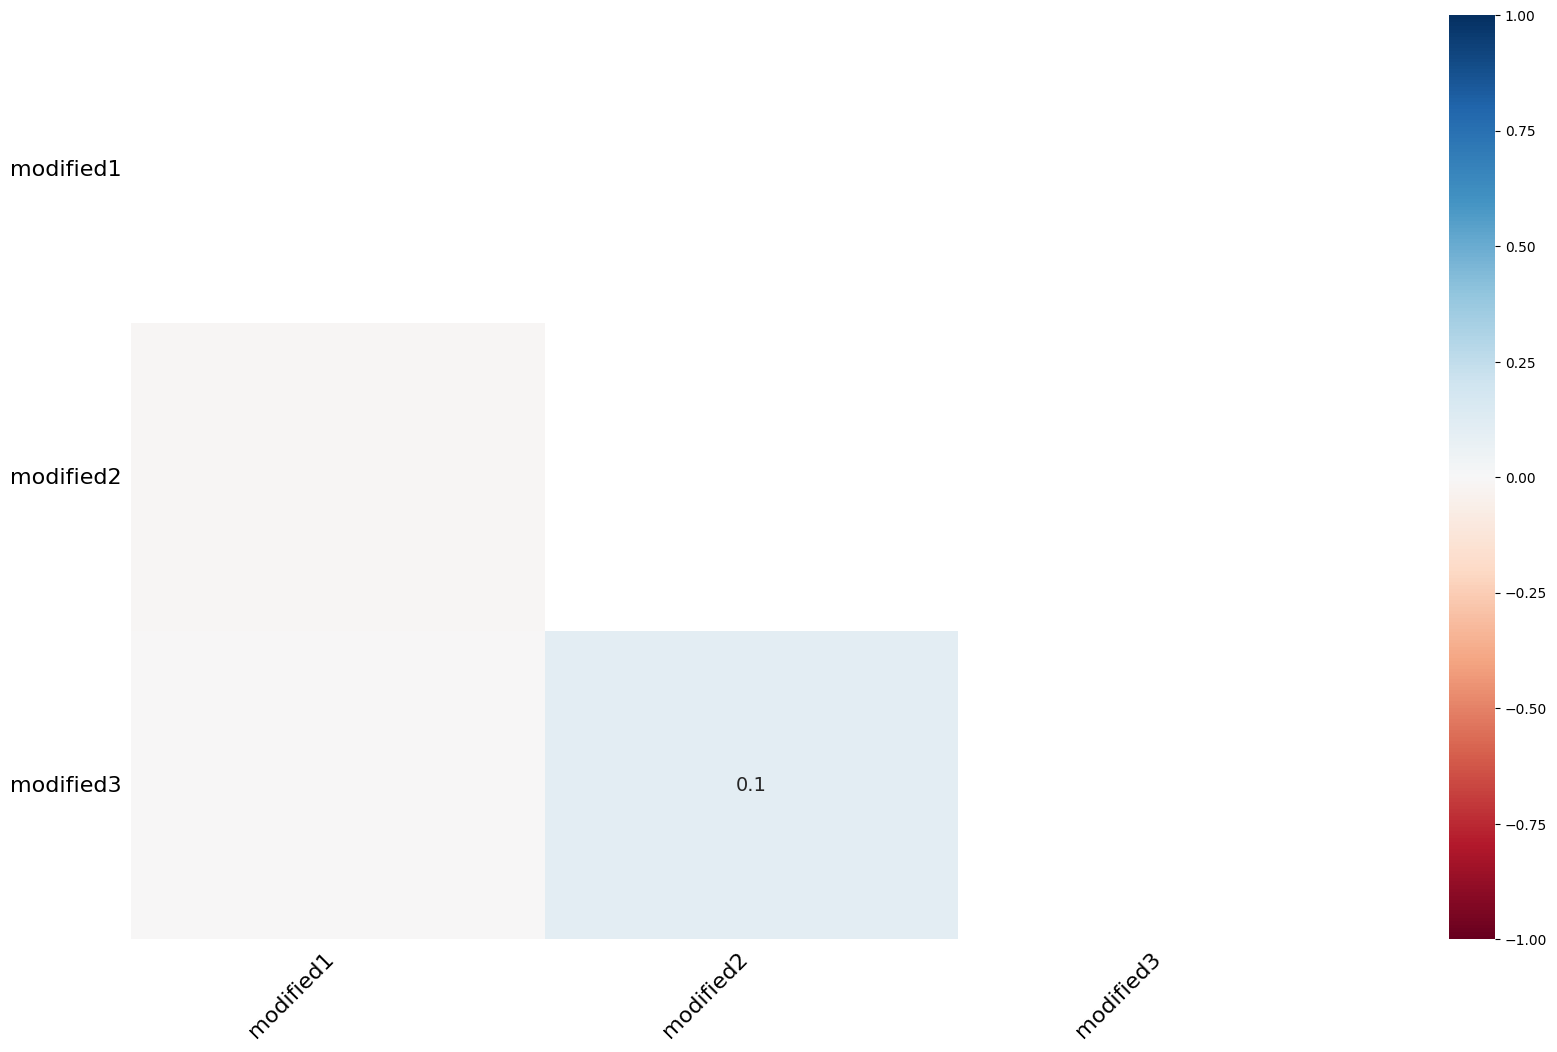

In [ ]:
# %%

# Visualize the missing values as a heatmap
msno.heatmap(data)
plt.show()

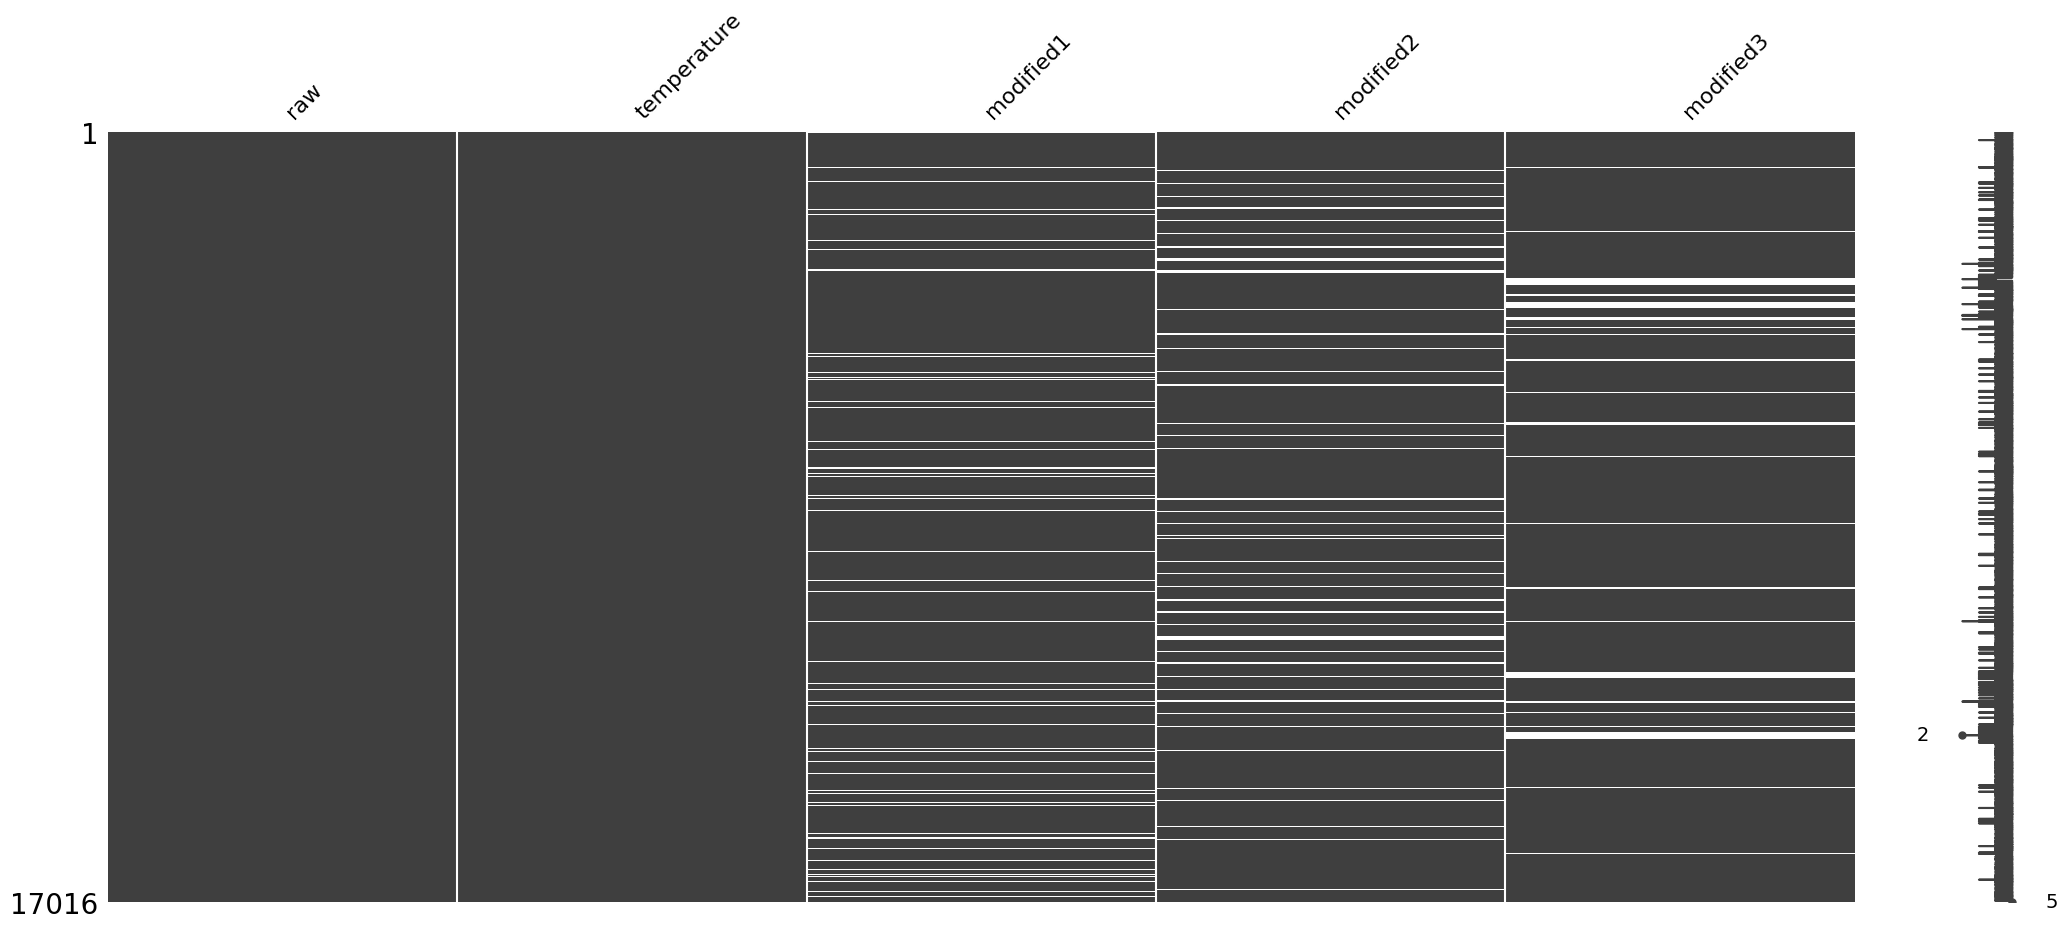

In [ ]:
# %%

# Visualize the missing values as a matrix
msno.matrix(data)
plt.show()

# %% [markdown]

 The timestamp, raw, temperature, and timestamp_unix columns have no missing values.

 The modified1, modified2, and modified3 columns show substantial missing data:
 1. modified1 has 1191 missing values.
 2. modified2 has 1375 missing values.
 3. modified3 has 1137 missing values.

 The percentage of missing values in the modified columns is approximately 7.25%.

 Visualizing the missing values using missingno does not reveal any specific patterns or correlations between the missing values in the modified columns.

In [ ]:
# %%

# Create new data frame with column indicating missingness (1 if missing, 0 otherwise) for each modified column
#
# as well as hour, day, month, and temperature for further analysis
data_missing = pd.DataFrame()
data_missing['modified1_missing'] = data['modified1'].isnull().astype(int)
data_missing['modified2_missing'] = data['modified2'].isnull().astype(int)
data_missing['modified3_missing'] = data['modified3'].isnull().astype(int)
data_missing['hour'] = data.index.hour
data_missing['day'] = data.index.day
data_missing['month'] = data.index.month
data_missing['weekday'] = data_missing.index.weekday

country_holidays = holidays.CountryHoliday('EE')
data_missing['is_holiday'] = data_missing.index.to_series().apply(
    lambda x: x in country_holidays)

data_missing['temperature'] = data['temperature']

data_missing.head(10)

,modified1_missing,modified2_missing,modified3_missing,hour,day,month,weekday,is_holiday,temperature
timestamp,,,,,,,,,
2021-02-02 00:00:00,0,0,0,0,2,2,1,False,-3.9
2021-02-02 01:00:00,0,0,0,1,2,2,1,False,-3.5
2021-02-02 02:00:00,0,0,0,2,2,2,1,False,-3.0
2021-02-02 03:00:00,0,0,0,3,2,2,1,False,-2.6
2021-02-02 04:00:00,0,0,0,4,2,2,1,False,-2.4
2021-02-02 05:00:00,0,0,0,5,2,2,1,False,-2.1
2021-02-02 06:00:00,1,0,0,6,2,2,1,False,-2.0
2021-02-02 07:00:00,0,0,0,7,2,2,1,False,-2.1
2021-02-02 08:00:00,0,0,0,8,2,2,1,False,-2.6


In [ ]:
# %%

# Check correlations between temperature and missingness indicators
correlation_with_temperature = data_missing.corr()
correlation_with_temperature

,modified1_missing,modified2_missing,modified3_missing,hour,day,month,weekday,is_holiday,temperature
modified1_missing,1.000000,-0.010345,-0.006071,9.483613e-04,-8.119527e-03,2.152855e-02,7.052037e-03,3.073409e-03,-0.009233
modified2_missing,-0.010345,1.000000,0.104595,-6.630507e-02,3.749123e-03,-2.606776e-02,2.632944e-03,1.697801e-03,0.116066
modified3_missing,-0.006071,0.104595,1.000000,4.458956e-02,2.076309e-02,2.525997e-02,-7.556411e-03,2.273642e-02,0.501724
hour,0.000948,-0.066305,0.044590,1.000000e+00,3.406801e-17,4.366289e-16,2.509063e-17,2.074886e-18,0.047183
day,-0.008120,0.003749,0.020763,3.406801e-17,1.000000e+00,-6.722101e-03,-1.207347e-02,2.896372e-02,0.073819
month,0.021529,-0.026068,0.025260,4.366289e-16,-6.722101e-03,1.000000e+00,-2.726223e-03,-4.095794e-03,0.078665
weekday,0.007052,0.002633,-0.007556,2.509063e-17,-1.207347e-02,-2.726223e-03,1.000000e+00,1.264532e-01,-0.007923
is_holiday,0.003073,0.001698,0.022736,2.074886e-18,2.896372e-02,-4.095794e-03,1.264532e-01,1.000000e+00,-0.050528
temperature,-0.009233,0.116066,0.501724,4.718348e-02,7.381889e-02,7.866458e-02,-7.922508e-03,-5.052844e-02,1.000000


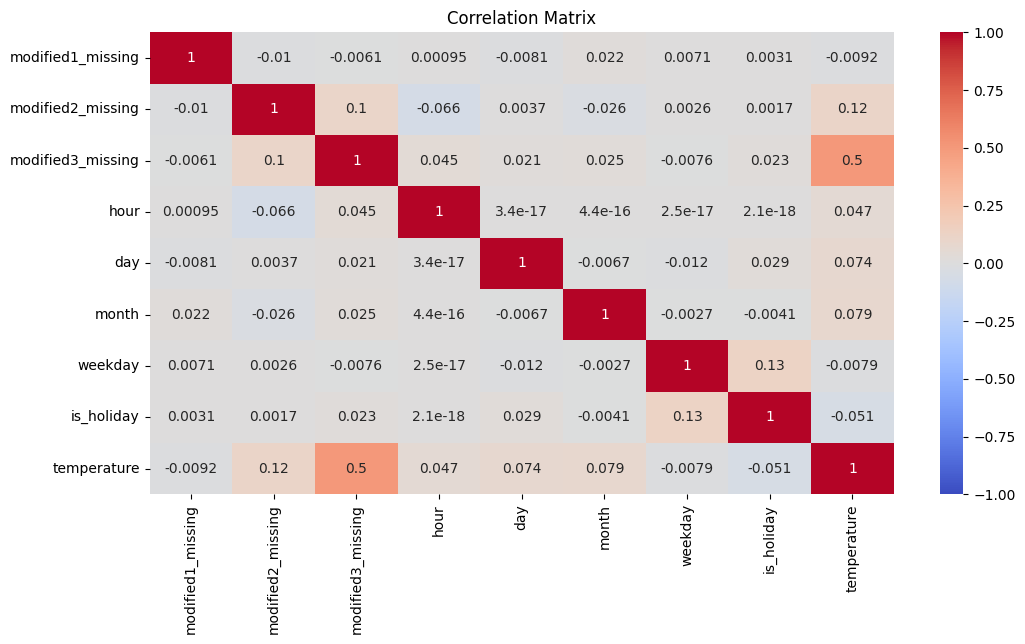

In [ ]:
# %%

# Plot correlation matrix as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_with_temperature, annot=True,
            cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

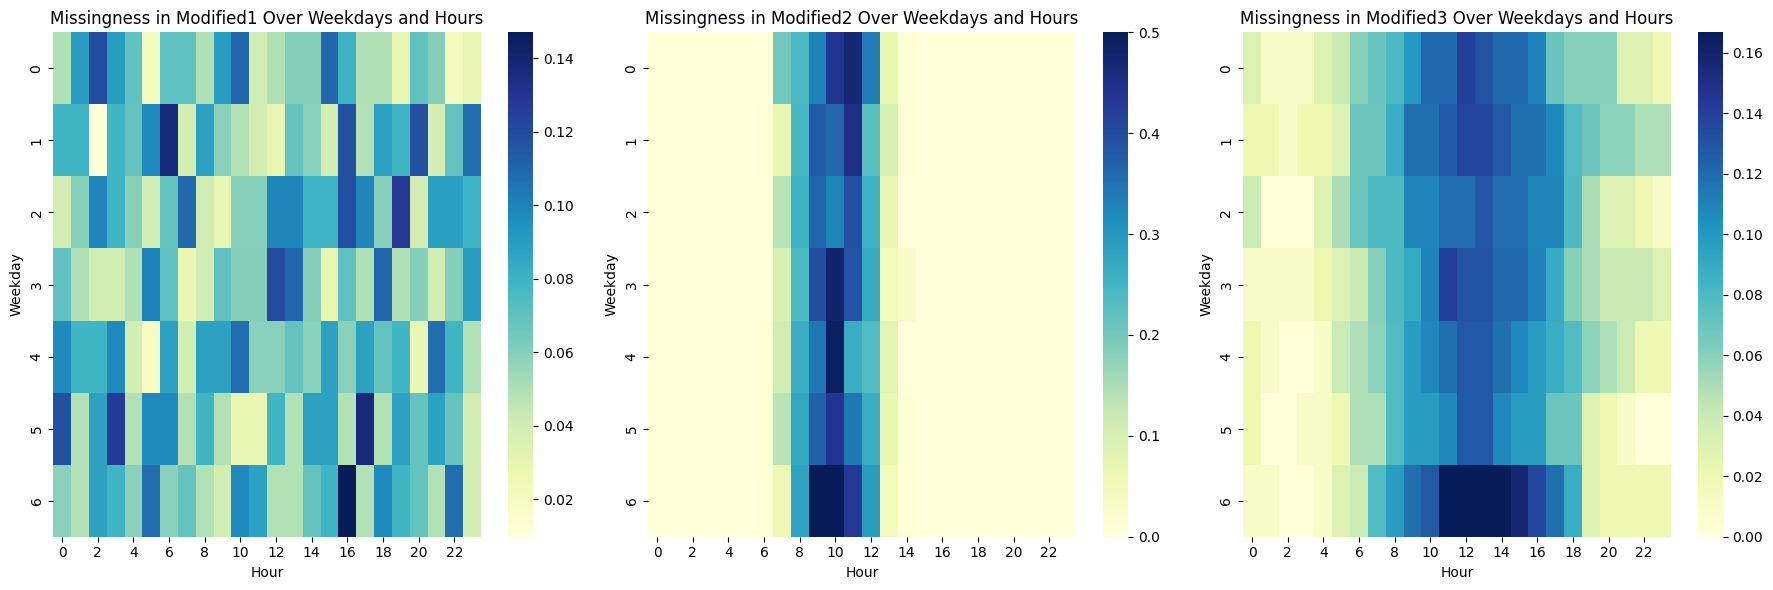

In [ ]:
# %%

# Create pivot table for missingness by weekday and hour
missingness_by_weekday_hour = data_missing.pivot_table(index='weekday', columns='hour',
                                                       values=[
                                                           'modified1_missing', 'modified2_missing', 'modified3_missing'],
                                                       aggfunc='mean')

# Plot heatmaps for each modified variable's missingness over weekdays and hours
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(
    missingness_by_weekday_hour['modified1_missing'], cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Missingness in Modified1 Over Weekdays and Hours')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Weekday')

sns.heatmap(
    missingness_by_weekday_hour['modified2_missing'], cmap="YlGnBu", ax=axes[1])
axes[1].set_title('Missingness in Modified2 Over Weekdays and Hours')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Weekday')

sns.heatmap(
    missingness_by_weekday_hour['modified3_missing'], cmap="YlGnBu", ax=axes[2])
axes[2].set_title('Missingness in Modified3 Over Weekdays and Hours')
axes[2].set_xlabel('Hour')
axes[2].set_ylabel('Weekday')

plt.tight_layout()
plt.show()

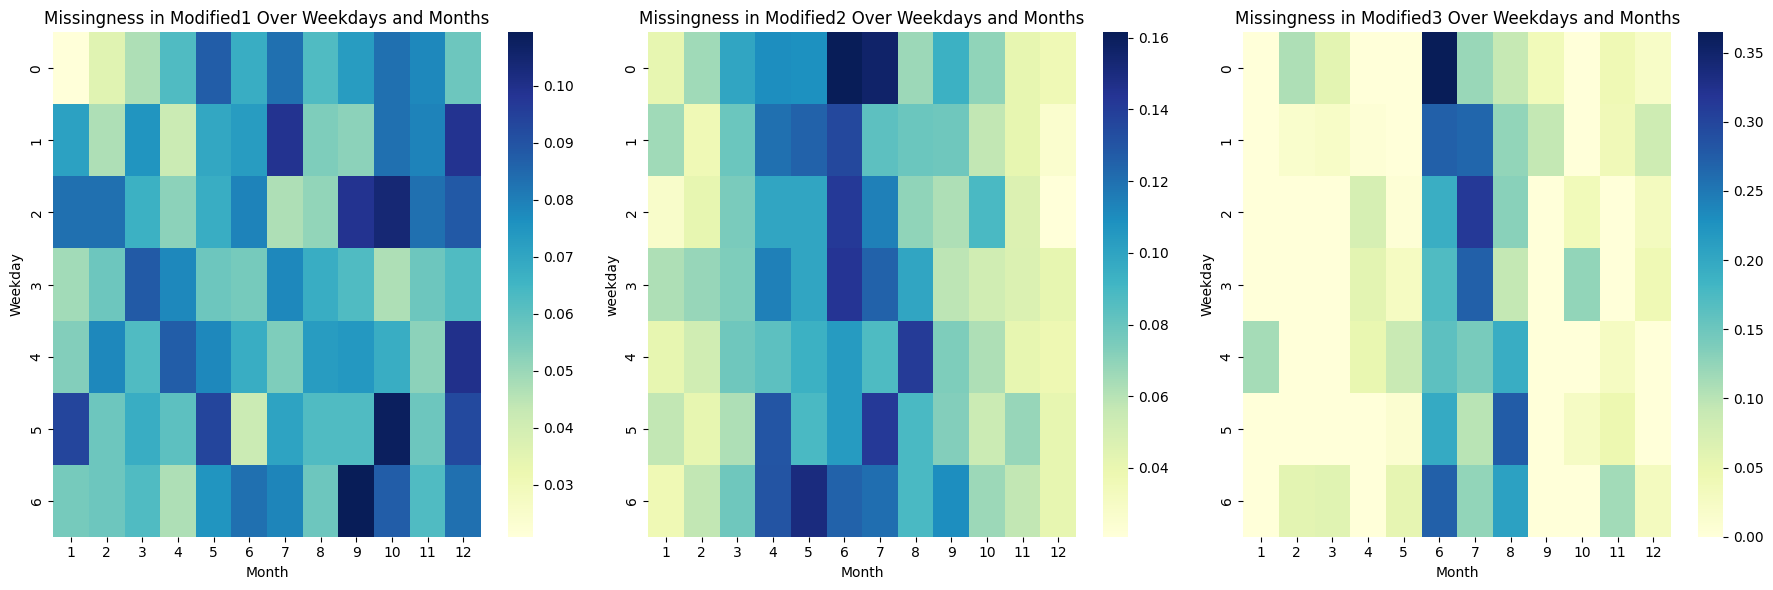

In [ ]:
# %%

# Create pivot table for missingness by weekday and month
missingness_by_weekday_month = data_missing.pivot_table(index='weekday', columns='month',
                                                        values=[
                                                            'modified1_missing', 'modified2_missing', 'modified3_missing'],
                                                        aggfunc='mean')

# Plot heatmaps for each modified variable's missingness over weekdays and months
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(
    missingness_by_weekday_month['modified1_missing'], cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Missingness in Modified1 Over Weekdays and Months')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Weekday')

sns.heatmap(
    missingness_by_weekday_month['modified2_missing'], cmap="YlGnBu", ax=axes[1])
axes[1].set_title('Missingness in Modified2 Over Weekdays and Months')
axes[1].set_xlabel('Month')

sns.heatmap(
    missingness_by_weekday_month['modified3_missing'], cmap="YlGnBu", ax=axes[2])
axes[2].set_title('Missingness in Modified3 Over Weekdays and Months')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Weekday')

plt.tight_layout()
plt.show()

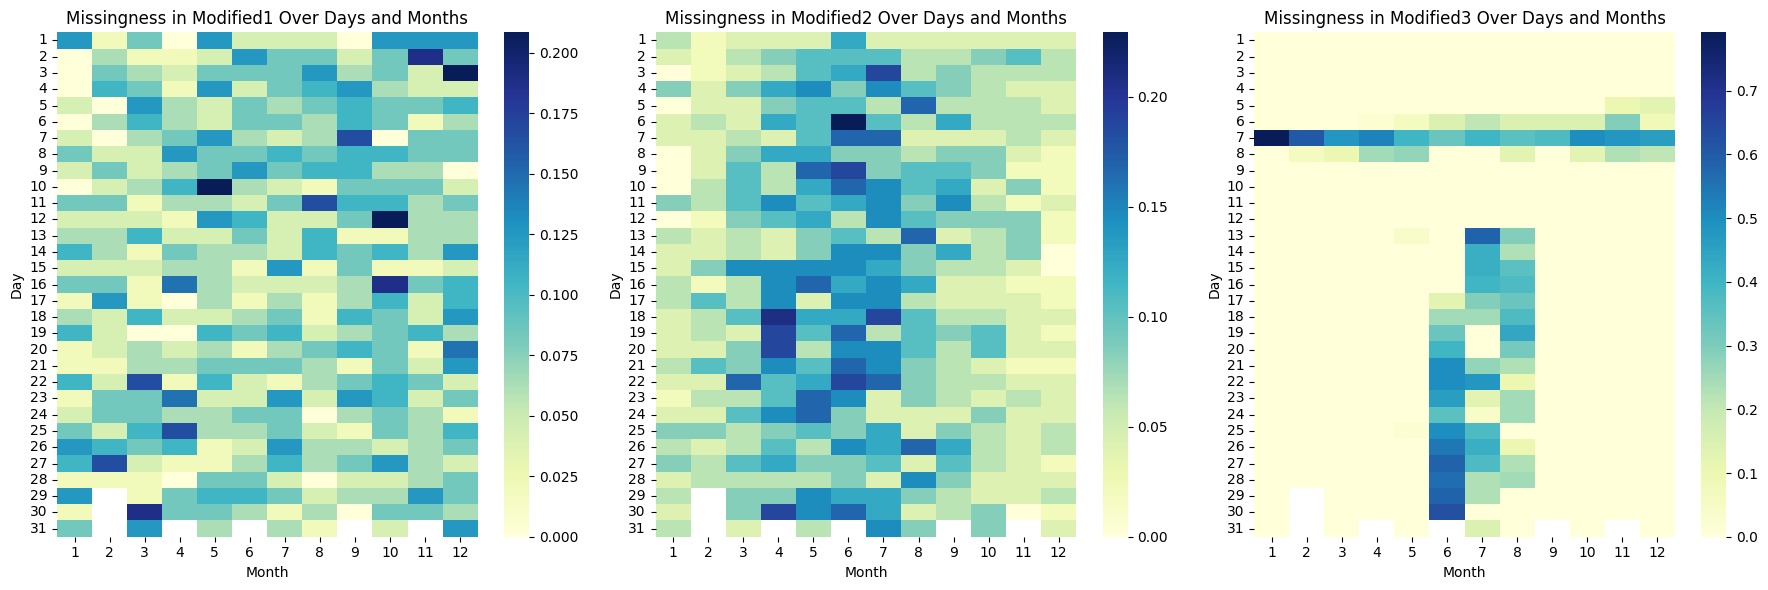

In [ ]:
# %%

# Create pivot table for missingness by day and month
missingness_by_day_month = data_missing.pivot_table(index='day', columns='month',
                                                    values=[
                                                        'modified1_missing', 'modified2_missing', 'modified3_missing'],
                                                    aggfunc='mean')

# Plot heatmaps for each modified variable's missingness over days and months
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(
    missingness_by_day_month['modified1_missing'], cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Missingness in Modified1 Over Days and Months')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Day')

sns.heatmap(
    missingness_by_day_month['modified2_missing'], cmap="YlGnBu", ax=axes[1])
axes[1].set_title('Missingness in Modified2 Over Days and Months')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Day')

sns.heatmap(
    missingness_by_day_month['modified3_missing'], cmap="YlGnBu", ax=axes[2])
axes[2].set_title('Missingness in Modified3 Over Days and Months')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Day')

plt.tight_layout()
plt.show()

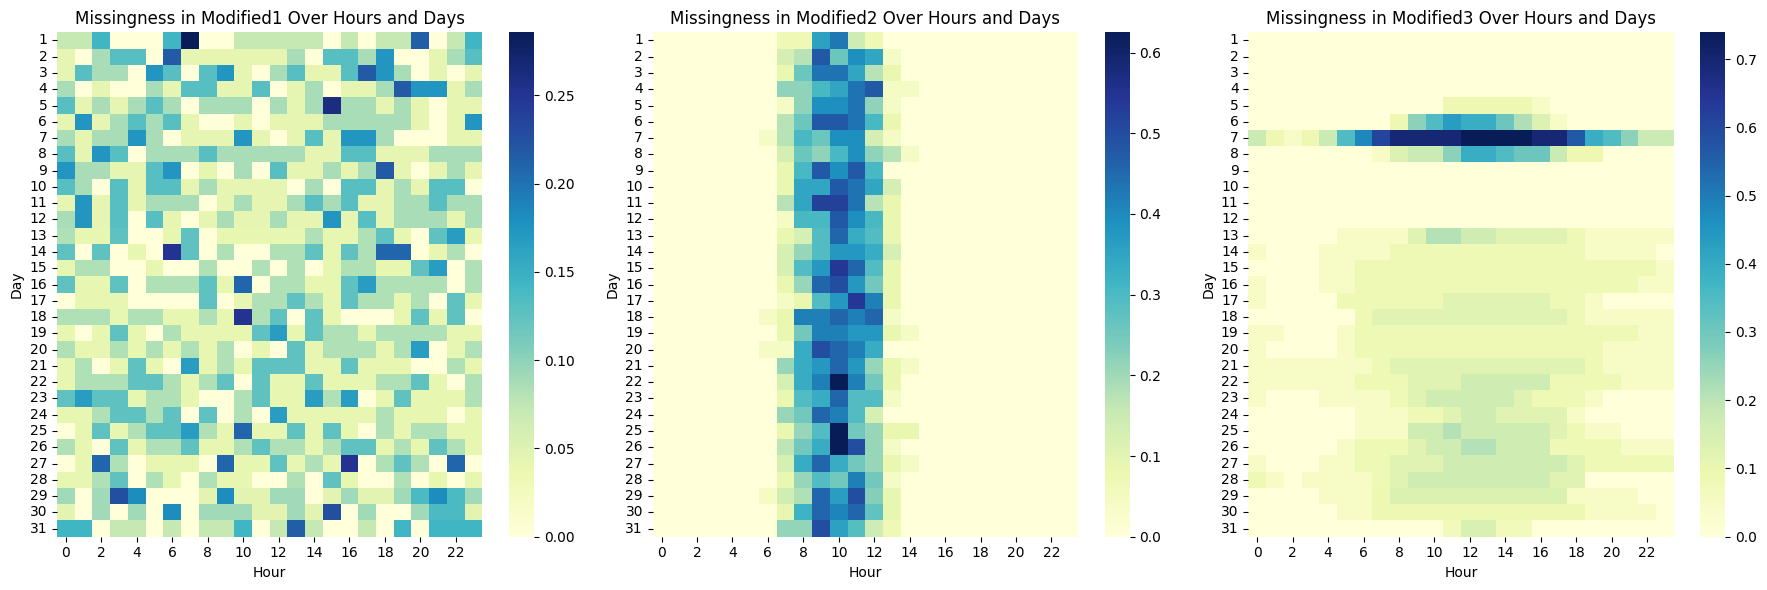

In [ ]:
# %%

# Create pivot table for missingness by hour and day
missingness_by_hour_day = data_missing.pivot_table(index='day', columns='hour',
                                                   values=[
                                                       'modified1_missing', 'modified2_missing', 'modified3_missing'],
                                                   aggfunc='mean')

# Plot heatmaps for each modified variable's missingness over days and hours
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(
    missingness_by_hour_day['modified1_missing'], cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Missingness in Modified1 Over Hours and Days')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Day')

sns.heatmap(
    missingness_by_hour_day['modified2_missing'], cmap="YlGnBu", ax=axes[1])
axes[1].set_title('Missingness in Modified2 Over Hours and Days')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Day')

sns.heatmap(
    missingness_by_hour_day['modified3_missing'], cmap="YlGnBu", ax=axes[2])
axes[2].set_title('Missingness in Modified3 Over Hours and Days')
axes[2].set_xlabel('Hour')
axes[2].set_ylabel('Day')

plt.tight_layout()
plt.show()

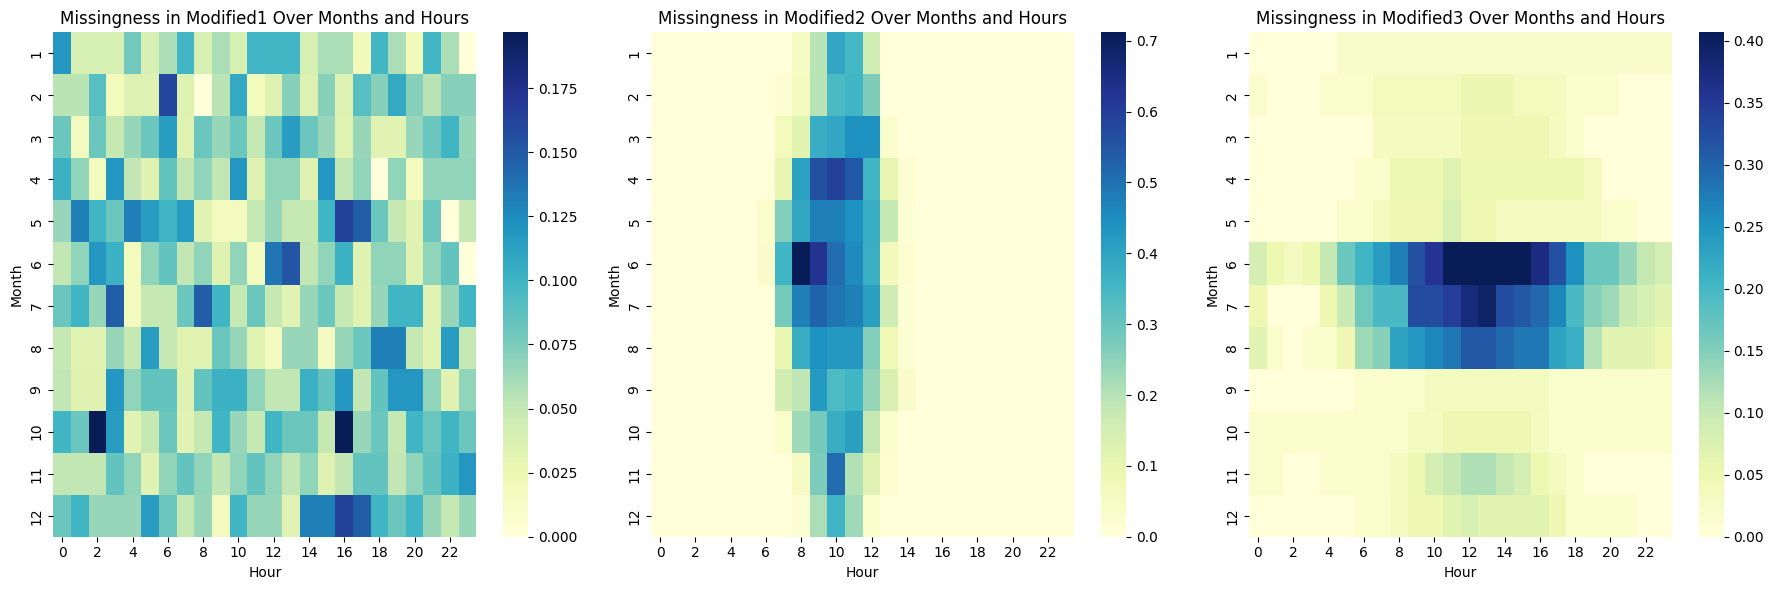

In [ ]:
# %%

# Create pivot table for missingness by month and hour
missingness_by_month_hour = data_missing.pivot_table(index='month', columns='hour',
                                                     values=[
                                                         'modified1_missing', 'modified2_missing', 'modified3_missing'],
                                                     aggfunc='mean')

# Plot heatmaps for each modified variable's missingness over months and hours
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(
    missingness_by_month_hour['modified1_missing'], cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Missingness in Modified1 Over Months and Hours')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Month')

sns.heatmap(
    missingness_by_month_hour['modified2_missing'], cmap="YlGnBu", ax=axes[1])
axes[1].set_title('Missingness in Modified2 Over Months and Hours')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Month')

sns.heatmap(
    missingness_by_month_hour['modified3_missing'], cmap="YlGnBu", ax=axes[2])
axes[2].set_title('Missingness in Modified3 Over Months and Hours')
axes[2].set_xlabel('Hour')
axes[2].set_ylabel('Month')

plt.tight_layout()
plt.show()

# %% [markdown]

 The missingness analysis of the `modified` columns reveals distinct patterns:
 1. **modified1_missing**: Missing values appear randomly with no observable patterns across time variables or temperature.
 2. **modified2_missing**: Missing data occurs exclusively between **7 AM and 12 PM** and is missing more during summer, indicating that missingness depends on the **hour of the day** and somewhat on the **month**.
 3. **modified3_missing**: Missingness is higher during the **summer months (June to August)** from **9 AM to 7 PM** peaking at 12AM when sun is commonly at high and correlates positively with **temperature** (correlation coefficient of **0.5**). Additionally, increased missingness is observed consistently specifically around the **7th day** of each month.

 **Conclusions**:
 - **modified1**: Missingness is **Missing Completely At Random (MCAR)** since it shows no relation to observed variables.
 - **modified2**: Missingness is **Missing At Random (MAR)** because it depends on the observed variable **hour**- and somewhat on **month**.
 - **modified3**: Missingness is **MAR** due to its dependence on **temperature** and **time variables**. However, the unexplained missingness on the **7th day** may suggest a separate **Missing At Random (MAR)** mechanism.